# <header>**Baseline model for Automated Essay Scoring competition**</header>

*Version 0.1.1*

In [1]:
!pip install torchview
!pip install torchinfo

# Utils

In [2]:
import random
from kaggle_secrets import UserSecretsClient
import wandb
import os
import datetime
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchview import draw_graph
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import LongformerModel, LongformerTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_ha")

wandb.login(key=wandb_api)

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

cpu


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
model_path = '/kaggle/input/essay-scoring-models/longformer-base-4096'
tokenizer = LongformerTokenizer.from_pretrained(model_path)
embedder = LongformerModel.from_pretrained(model_path, attention_window=128)

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [3]:
data_dir = "/kaggle/input/aes-linguistic"

ling_features = []
with open(os.path.join(data_dir, 'features.txt'), 'r') as f:
    ling_features = f.read().splitlines()
    
ling_features = list(set(ling_features))

# data_dir = "../../output/"
train_data = pd.read_csv(os.path.join(data_dir, 'train_linguistic.csv'))
extra_data = pd.read_csv(os.path.join(data_dir, 'extra_linguistic.csv'))

extra_data = extra_data[~extra_data['full_text'].isna()]
train_data = train_data[~train_data['full_text'].isna()]

train_data = train_data[['essay_id', 'full_text', 'score'] + ling_features]
extra_data = extra_data[['essay_id', 'full_text', 'score'] + ling_features]

train_data = train_data.drop_duplicates()
extra_data = extra_data.drop_duplicates()

train_data = train_data.reset_index(drop=True)
extra_data = extra_data.reset_index(drop=True)

print(train_data.shape, extra_data.shape)

train_data.sample(5)

(17307, 119) (13125, 119)


,essay_id,full_text,score,min_num_nouns_in_paragraph,75th_percentile_num_pronouns_in_paragraph,max_num_nouns_in_paragraph,25th_percentile_num_misspelled_words_in_paragraph,mean_word_lens_in_essay,min_num_sentences_in_paragraph,75th_percentile_num_misspelled_words_in_sentence,...,25th_percentile_num_adverbs_in_paragraph,mean_num_verbs_in_paragraph,75th_percentile_num_conjunctions_in_sentence,mean_num_words_in_sentence,75th_percentile_num_misspelled_words_in_paragraph,mean_num_words_in_paragraph,max_num_proper_nouns_in_sentence,25th_percentile_num_sentences_in_paragraph,min_num_conjunctions_in_paragraph,max_num_adjectives_in_sentence
12696,bb4c434,"people tend to use there cars so much, they ba...",3,0,13.0,28,106.00,111.563946,1,27.75,...,2.0,14.666667,2.0,20.200000,135.0,104.433333,3,5.00,0,6
4625,44e88b0,imagine being a top scientist at nasa and viki...,3,9,5.0,33,85.00,90.464746,2,24.00,...,2.0,8.863636,1.0,19.409091,112.0,95.772727,1,5.00,1,6
733,0ba78ec,the face of mars could not be created by alien...,3,11,11.0,23,60.75,49.791260,3,21.25,...,2.0,5.250000,2.0,20.083333,124.0,91.250000,3,3.00,2,4
16885,f96c287,many people belive that the face on mars was c...,3,5,3.0,18,49.50,56.699297,2,26.50,...,1.0,5.785714,1.0,19.214286,65.0,57.071429,3,2.25,0,4
3334,317173f,driverless cars are coming soon or later? peop...,4,12,15.0,31,104.00,130.349517,1,25.00,...,3.0,15.515152,2.0,19.484848,136.0,119.090909,0,6.00,4,5


Split train, val, test set

In [4]:
all_data = pd.concat([train_data, extra_data], ignore_index=True)

# drop columns with nan values
nan_columns = all_data.columns[all_data.isna().any()].tolist()
all_data = all_data.drop(columns=nan_columns)
ling_features = list(set(ling_features).difference(nan_columns))
print(len(ling_features))

# shuffle the data
all_data = all_data.sample(frac=1, random_state=random_seed)
all_data = all_data.reset_index(drop=True)

train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1

train_df, val_df = train_test_split(all_data, test_size=val_ratio + test_ratio, 
                                    random_state=random_seed)
val_df, test_df = train_test_split(val_df, test_size=test_ratio/(val_ratio + test_ratio), 
                                   random_state=random_seed)

print(train_df.shape, val_df.shape, test_df.shape)

116
(24345, 119) (3043, 119) (3044, 119)


Hyperparameters

In [5]:
hyperparameters = {
    'lr': 5e-5,
    'dropout': 0.5,
    'epochs': 10,
    'batch_size': 64,
    'train_set': {
        'total': len(train_df),
        'ratio': train_ratio,
    },
    'val_set': {
        'total': len(val_df),
        'ratio': val_ratio,
    },
    'test_set': {
        'total': len(test_df),
        'ratio': test_ratio,
    },
    'linguistic_features': ling_features,
    'accelator': str(device)
}

In [7]:
train_tokenized = tokenizer(train_df['full_text'].tolist(),
                            padding=True, 
                            return_tensors="np")

hyperparameters['max_seq_len'] = train_tokenized['input_ids'].shape[1]

train_df['input_ids'] = train_tokenized['input_ids'].tolist()
train_df['attention_mask'] = train_tokenized['attention_mask'].tolist()


print(len(train_df.sample(1).iloc[0]['input_ids']))

1929


In [8]:
val_tokenized = tokenizer(val_df['full_text'].tolist(),
                          max_length=hyperparameters['max_seq_len'],
                          padding='max_length', truncation=True, 
                          return_tensors="np")

val_df['input_ids'] = val_tokenized['input_ids'].tolist()
val_df['attention_mask'] = val_tokenized['attention_mask'].tolist()


print(len(val_df.sample(1).iloc[0]['input_ids']))

1929


In [9]:
test_tokenized = tokenizer(test_df['full_text'].tolist(),
                           max_length=hyperparameters['max_seq_len'], 
                           padding='max_length', truncation=True, 
                           return_tensors="np")

test_df['input_ids'] = test_tokenized['input_ids'].tolist()
test_df['attention_mask'] = test_tokenized['attention_mask'].tolist()

print(len(test_df.sample(1).iloc[0]['input_ids']))

1929


In [10]:
class MultiFeaturesDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.token_ids = df['input_ids'].values
        self.attention_mask = df['attention_mask'].values
        self.score = df['score'].values
        self.ling_features = []
        for feature in ling_features:
            self.ling_features.append(df[feature].values)

    def __len__(self):
        return len(self.score)

    def __getitem__(self, idx):
        features = []
        for feature in self.ling_features:
            features.append(feature[idx])

        features = torch.tensor(features, dtype=torch.float)

        score = torch.reshape(torch.tensor(
            self.score[idx], dtype=torch.float), (1,))

        return torch.tensor(self.token_ids[idx]), torch.tensor(self.attention_mask[idx]), features, score


train_dataset = MultiFeaturesDataset(train_df)
val_dataset = MultiFeaturesDataset(val_df)

In [11]:
train_dataloader = DataLoader(
    train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
val_dataloader = DataLoader(
    val_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)

for token_ids, attention_mask, features, score in val_dataloader:
    print(token_ids.shape, attention_mask.shape, features.shape, score.shape)
    break

torch.Size([64, 1929]) torch.Size([64, 1929]) torch.Size([64, 116]) torch.Size([64, 1])


In [12]:
class MultiFeaturesModel(torch.nn.Module):
    def __init__(self, embedder,
                 lf_input_size, lf_hidden_size=64,
                 dropout=0.2):
        super(MultiFeaturesModel, self).__init__()
        # freeze
        for param in embedder.parameters():
            param.requires_grad = False
        # unfreeze the pooler
        for param in embedder.pooler.parameters():
            param.requires_grad = True
            
        self.embedder = embedder
        self.lf = torch.nn.Linear(lf_input_size,lf_hidden_size)
        # self.fc1 = torch.nn.Linear(lf_hidden_size + embedder.config.hidden_size, 256)
        # self.fc2 = torch.nn.Linear(256, 128)
        self.regressor = torch.nn.Linear(lf_hidden_size + embedder.config.hidden_size, 1)
        self.dropout = torch.nn.Dropout(dropout)
    
    def config(self):
        return {
            'embedder': self.embedder.config,
            'lf': {
                'input_size': self.lf.in_features,
                'hidden_size': self.lf.out_features
            },
#             'fc1': {
#                 'input_size': self.fc1.in_features,
#                 'output_size': self.fc1.out_features
#             },
#             'fc2': {
#                 'input_size': self.fc2.in_features,
#                 'output_size': self.fc2.out_features
#             },
            'regressor': {
                'input_size': self.regressor.in_features,
                'output_size': self.regressor.out_features
            }
        }

    def forward(self, token_ids, attention_mask, ling_features):
        embedded = self.embedder(token_ids, attention_mask=attention_mask, output_hidden_states=True)[1]
        if self.training:
            embedded = self.dropout(embedded)
            
        ling_features = self.lf(ling_features)
        ling_features = F.leaky_relu(ling_features)
        if self.training:
            ling_features = self.dropout(ling_features)
            
        features = torch.cat((embedded, ling_features), dim=1)

        # fc1 = self.fc1(features)
        # fc1 = F.leaky_relu(fc1)
        # if self.training:
        #     fc1 = self.dropout(fc1)
        
        # fc2 = self.fc2(fc1)
        # fc2 = F.leaky_relu(fc2)
        # if self.training:
        #     fc2 = self.dropout(fc2)
            
        # score = self.regressor(fc2)
        score = self.regressor(features)
        return score


model = MultiFeaturesModel(embedder, 
                           len(ling_features), 128,
                           hyperparameters['dropout'])
# model.to(device)

inputs = next(iter(train_dataloader))[:-1]
# inputs.to(device)
model_summary = summary(model, input_data=inputs)

print(model_summary)

Input ids are automatically padded from 1929 to 2048 to be a multiple of `config.attention_window`: 128


Layer (type:depth-idx)                                       Output Shape              Param #
MultiFeaturesModel                                           [64, 1]                   --
├─LongformerModel: 1-1                                       [64, 1929, 768]           --
│    └─LongformerEmbeddings: 2-1                             [64, 2048, 768]           --
│    │    └─Embedding: 3-1                                   [64, 2048, 768]           (38,603,520)
│    │    └─Embedding: 3-2                                   [64, 2048, 768]           (3,147,264)
│    │    └─Embedding: 3-3                                   [64, 2048, 768]           (768)
│    │    └─LayerNorm: 3-4                                   [64, 2048, 768]           (1,536)
│    │    └─Dropout: 3-5                                     [64, 2048, 768]           --
│    └─LongformerEncoder: 2-2                                [64, 1929, 768]           --
│    │    └─ModuleList: 3-6                                  --     

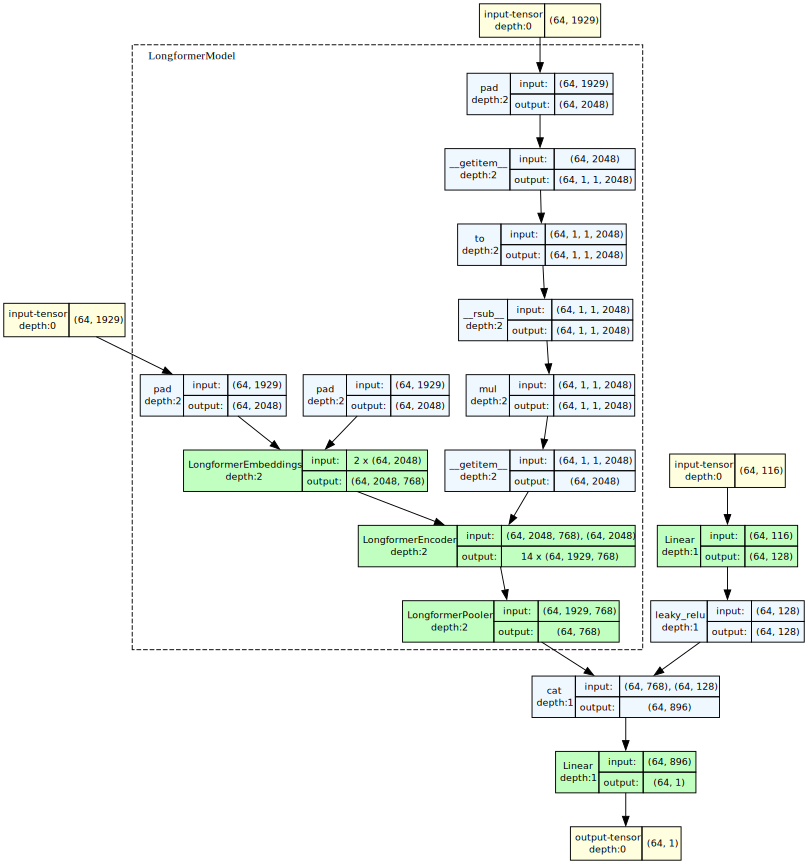

In [13]:
model_graph = draw_graph(model,
                         input_data=inputs,
                         expand_nested=True,
                         depth=2)
model_graph.visual_graph

In [14]:
def train(model, optimizer, criterion, train_dataloader, logging_steps=20):
    model.train()
    running_loss = 0.0

    for i, (token_ids, attention_mask, features, score) in enumerate(train_dataloader):

        output = model(token_ids.to(device),
                       attention_mask.to(device),
                       features.to(device))
    
        loss = criterion(output, score.to(device)).float()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        
#         if i == 5:
#             break
        
        if (i + 1) % (logging_steps) == 0 or (i + 1) == len(train_dataloader):
            wandb.log({'train_loss_steps': running_loss / (i + 1),
                       'learning_rate': optimizer.param_groups[0]['lr']})

    return running_loss / len(train_dataloader)


def evaluate(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    all_scores = []
    predictions = []

    with torch.no_grad():
        for token_ids, attention_mask, features, score in dataloader:
            output = model(token_ids.to(device),
                           attention_mask.to(device),
                           features.to(device))

            loss = criterion(output, score.to(device)).float()
            
#             print(loss)

            running_loss += loss.item()
            all_scores.extend(score.cpu().numpy())
            predictions.extend(output.cpu().numpy())
            
#             break

    return running_loss / len(dataloader), torch.tensor(all_scores), torch.tensor(predictions)

In [14]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [16]:
def logit_to_score(logit, min_score=1, max_score=6):
    scores = torch.clamp(torch.round(logit), min_score, max_score)
    scores = scores.long()
    return scores

In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=hyperparameters['lr'],
                             weight_decay=1e-8)
scheduler = ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
early_stopper = EarlyStopper(patience=5, min_delta=1e-6)

train_losses, val_losses, val_kappa_scores, val_accuracies = [], [], [], []

hyperparameters['early_stopper'] = early_stopper.__dict__['patience']
hyperparameters['scheduler'] = scheduler.__dict__
hyperparameters['model'] = model.config()

hyperparameters

{'lr': 5e-05,
 'dropout': 0.5,
 'epochs': 10,
 'batch_size': 64,
 'train_set': {'total': 24345, 'ratio': 0.8},
 'val_set': {'total': 3043, 'ratio': 0.1},
 'test_set': {'total': 3044, 'ratio': 0.1},
 'linguistic_features': ['max_num_misspelled_words_in_paragraph',
  '25th_percentile_num_verbs_in_paragraph',
  'min_num_words_in_sentence',
  'min_num_nouns_in_paragraph',
  'mean_num_proper_nouns_in_sentence',
  '75th_percentile_num_pronouns_in_paragraph',
  'max_num_nouns_in_paragraph',
  '25th_percentile_num_misspelled_words_in_paragraph',
  '75th_percentile_num_adjectives_in_sentence',
  'mean_word_lens_in_essay',
  'min_num_sentences_in_paragraph',
  'min_num_verbs_in_sentence',
  '75th_percentile_num_misspelled_words_in_sentence',
  'min_num_nouns_in_sentence',
  'num_verbs_in_essay',
  '25th_percentile_mean_word_lens_in_paragraph',
  '75th_percentile_num_words_in_sentence',
  'max_num_sentences_in_paragraph',
  'max_num_adverbs_in_sentence',
  'max_num_pronouns_in_sentence',
  'mean_

In [18]:
torch.cuda.empty_cache()
model.to(device)

wandb.init(project='deep-essay-scoring', config=hyperparameters)

print("Start training...")

for epoch in range(hyperparameters['epochs']):
    train_loss = train(model, optimizer, criterion, train_dataloader)
    train_losses.append(train_loss)

    val_loss, val_scores, val_predictions = evaluate(
        model, criterion, val_dataloader)
    val_kappa = cohen_kappa_score(val_scores.cpu().numpy(),
                                  logit_to_score(
                                      val_predictions).cpu().numpy(),
                                  weights='quadratic')

    val_accuracy = torch.sum(val_scores == logit_to_score(
        val_predictions)).float() / len(val_scores)

    val_losses.append(val_loss)
    val_kappa_scores.append(val_kappa)
    val_accuracies.append(val_accuracy)

    scheduler.step(val_loss)

    wandb.log({'train_loss': train_loss, 'val_loss': val_loss,
              'val_kappa': val_kappa, 'epoch': epoch+1})

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Kappa: {val_kappa}, Val Accuracy: {val_accuracy}')

#     break

#     if early_stopper.early_stop(val_losses[-1]):
#         print("Early stopping")
#         break

wandb: Currently logged in as: minha-lehoang. Use `wandb login --relogin` to force relogin

wandb: wandb version 0.17.0 is available!  To upgrade, please run:

wandb:  $ pip install wandb --upgrade

wandb: Tracking run with wandb version 0.16.6

wandb: Run data is saved locally in /kaggle/working/wandb/run-20240510_094741-v5gg0iis

wandb: Run `wandb offline` to turn off syncing.

wandb: Syncing run hopeful-paper-52

wandb: ⭐️ View project at https://wandb.ai/minha-lehoang/deep-essay-scoring

wandb: 🚀 View run at https://wandb.ai/minha-lehoang/deep-essay-scoring/runs/v5gg0iis


Start training...


/tmp/ipykernel_25/2725391327.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)

  return running_loss / len(dataloader), torch.tensor(all_scores), torch.tensor(predictions)


Epoch: 1, Train Loss: 32.72801229271676, Val Loss: 2.9949976752201715, Val Kappa: 0.12970771833222716, Val Accuracy: 0.2178770899772644

Epoch: 2, Train Loss: 25.42686035877138, Val Loss: 1.4183755678435166, Val Kappa: 0.43911191003179095, Val Accuracy: 0.3450542092323303

Epoch: 3, Train Loss: 19.586593365106058, Val Loss: 0.9352783461411794, Val Kappa: 0.5843956548973925, Val Accuracy: 0.4186657965183258

Epoch: 4, Train Loss: 15.524498639144296, Val Loss: 0.7992416297396024, Val Kappa: 0.6252752574095003, Val Accuracy: 0.43674007058143616

Epoch: 5, Train Loss: 12.936583020868577, Val Loss: 0.6804117995003859, Val Kappa: 0.6828650720588013, Val Accuracy: 0.4886625111103058


In [19]:
# Get current date and time
now = datetime.datetime.now()
now_str = now.strftime("%YY-%mm-%dd") 

embedder_name = model_path.split('/')[-1]
model_name = f'multi_features_{embedder_name}_{now_str}_model'

# Save the model
with open(f'{model_name}_summary.txt', 'w') as f:
    f.write(str(model_summary))

torch.save(model.state_dict(), f'{model_name}.pth')

In [20]:
torch.cuda.empty_cache()

In [21]:
model.eval()
test_predictions = []

with torch.no_grad():
    for i, row in test_df.iterrows():
        token_ids = torch.tensor(row['input_ids']).unsqueeze(0)
        attention_mask = torch.tensor(row['attention_mask']).unsqueeze(0)
        row_ling_features = torch.tensor(row[ling_features].tolist()).unsqueeze(0)

        output = model(token_ids.to(device), 
                       attention_mask.to(device), 
                       row_ling_features.to(device))
        test_predictions.append(output.item())
        
submit_df = pd.DataFrame({
    'essay_id': test_df['essay_id'],
    'prediction': logit_to_score(torch.tensor(test_predictions)).cpu().numpy()
})
print(submit_df.shape)
submit_df.to_csv('submission.csv', index=False)

(3044, 2)
